In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch

In [ ]:
from pathlib import Path
cats_dir=Path("/content/drive/MyDrive/Colab Notebooks/Data/dogs_vs_cats/data/cats")
dogs_dir=Path("/content/drive/MyDrive/Colab Notebooks/Data/dogs_vs_cats/data/dogs")
if dogs_dir.is_dir():
  print(f"{dogs_dir} is a directory")
else:
  print("Not a directory")

if cats_dir.is_dir():
  print(f"{cats_dir} is a directory")
else:
  print("Not a directory")

/content/drive/MyDrive/Colab Notebooks/Data/dogs_vs_cats/data/dogs is a directory
/content/drive/MyDrive/Colab Notebooks/Data/dogs_vs_cats/data/cats is a directory


In [ ]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import random
from sklearn.model_selection import train_test_split

class ImageDataset(Dataset):
    def __init__(self, img_dirs, transform=None, is_train=True):
        self.img_dirs = img_dirs
        self.transform = transform
        self.is_train = is_train  # Kiểm tra nếu là tập huấn luyện hay tập kiểm tra
        self.image_labels = []

        # Duyệt qua các thư mục ảnh và gán nhãn
        for img_dir in img_dirs:
            for img_name in os.listdir(img_dir):
                label = img_name.split('.')[0]  # Lấy tên thư mục làm nhãn (dog hoặc cat)
                label = 0 if label == 'dog' else 1  # Chuyển nhãn thành số (0 cho chó, 1 cho mèo)
                self.image_labels.append((img_name, label))

        # Xáo trộn danh sách ảnh và nhãn
        random.shuffle(self.image_labels)

        # Chia dữ liệu thành train và test
        if self.is_train:
            self.image_labels = self.image_labels[:int(len(self.image_labels)*0.8)]  # 80% là train
        else:
            self.image_labels = self.image_labels[int(len(self.image_labels)*0.8):]  # 20% là test

    def __len__(self):
        return len(self.image_labels)

    def __getitem__(self, idx):
        try:
            img_name, label = self.image_labels[idx]
            img_dir = self.img_dirs[label]
            img_path = os.path.join(img_dir, img_name)

            # # Debugging print statements

            # print(f"Label: {label}")

            image = Image.open(img_path)

            # Debugging print statement


            if self.transform:
                image = self.transform(image)

            # Debugging print statement
            # print(f"Image shape after transform:")

            return image, label

        except Exception as e:
            print(f"Error processing image {img_path}: {e}")
            # Handle the exception (e.g., return a default image or skip the sample)
            return None, None # or raise e to stop execution


# Định nghĩa các phép biến đổi


transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize ảnh về kích thước chuẩn
    transforms.ToTensor(),  # Chuyển ảnh thành tensor (giá trị pixel nằm trong [0, 1])
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])


# Khởi tạo dataset và DataLoader
img_dirs = [dogs_dir,cats_dir]  # Danh sách các thư mục ảnh (dogs và cats)

# Tạo dataset cho tập huấn luyện và kiểm tra
train_dataset = ImageDataset(img_dirs, transform=transform, is_train=True)
test_dataset = ImageDataset(img_dirs, transform=transform, is_train=False)

# Tạo DataLoader cho tập huấn luyện và kiểm tra
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True,num_workers=2)

print(len(train_dataset))
print(len(test_dataset))


3812
954


In [ ]:
# Đếm số lượng ảnh, fake và real trong dataset
def count_labels(loader):
    total_images = 0
    fake_count = 0
    real_count = 0

    for images, labels in loader:
        total_images += len(images)  # Đếm số ảnh trong mỗi batch
        fake_count += (labels == 0).sum().item()  # Đếm số ảnh dog
        real_count += (labels == 1).sum().item()  # Đếm số ảnh cat

    return total_images, fake_count, real_count

# Đếm trong train_loader
train_total, train_fake, train_real = count_labels(train_loader)
print(f"Train - Total: {train_total}, Dog: {train_fake}, Cat: {train_real}")

# Đếm trong test_loader
test_total, test_fake, test_real = count_labels(test_loader)
print(f"Test - Total: {test_total}, Dog: {test_fake}, Cat: {test_real}")

Train - Total: 3812, Dog: 1794, Cat: 2018
Test - Total: 954, Dog: 454, Cat: 500


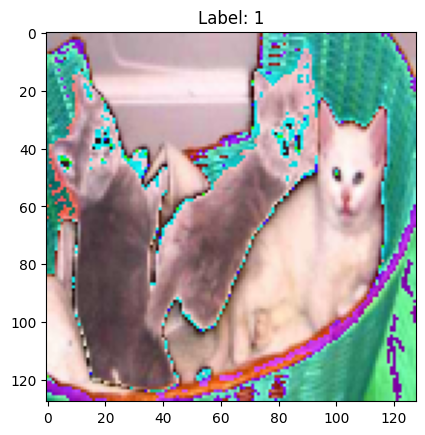

tensor(1)


In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Lấy một batch từ train_loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Chọn ảnh đầu tiên trong batch
first_image = images[0]  # Chọn ảnh đầu tiên trong batch
first_label = labels[0]  # Nhãn tương ứng

# Chuyển tensor về hình ảnh để hiển thị
first_image_pil = F.to_pil_image(first_image)

# Hiển thị ảnh
plt.imshow(first_image_pil)
plt.title(f'Label: {first_label.item()}')  # Hiển thị nhãn của ảnh
plt.show()
print(first_label)

In [ ]:
import torch
import torch.nn as nn
from torchsummary import summary

class VGG16V1(nn.Module):
    def __init__(self, input_shape: int,

                 output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=64,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Conv2d(in_channels=64,
                      out_channels=64,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(in_channels=128,
                      out_channels=128,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block_3 = nn.Sequential(
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block_4=nn.Sequential(
            nn.Conv2d(in_channels=256,
                      out_channels=512,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, inplace=True),

            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block_5=nn.Sequential(
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.classifier = nn.Sequential(

            nn.Flatten(),
            nn.Linear(in_features=8192, out_features=4096),  # Lớp ẩn đầu tiên
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096, out_features=1000),     # Lớp ẩn thứ hai
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.5),
            nn.Linear(in_features=1000, out_features=output_shape)  # Lớp đầu ra
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x= self.block_5(x)
        x = self.classifier(x)
        return x



In [ ]:
model_0 = VGG16V1(3,2).to(device)

In [ ]:
input_shape = 3  # Ảnh đầu vào có 3 kênh (RGB)
output_shape = 2  # Ví dụ: phân loại thành 2 lớp
summary(model_0,(input_shape,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
         LeakyReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
         LeakyReLU-6         [-1, 64, 128, 128]               0
         MaxPool2d-7           [-1, 64, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]          73,856
       BatchNorm2d-9          [-1, 128, 64, 64]             256
        LeakyReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
        LeakyReLU-13          [-1, 128, 64, 64]               0
        MaxPool2d-14          [-1, 128,

In [ ]:
model_0.to(device)
first_image=first_image.unsqueeze(dim=0).to(device)
model_0(first_image)

tensor([[-0.0391, -0.0516]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0


    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()  # print(f"Image shape after transform: {image.shape}")


        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels =  torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [ ]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module ,
          epochs: int = 50):
    best_acc=0.0;


    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_loader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_loader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )
        val_acc=test_acc
        if val_acc>best_acc:
          best_acc=val_acc
          torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/Model/best_model_V1.pth')
          print(f"Model saved with accuarancy: {best_acc}")
        #

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results






In [ ]:
#setup a loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.0001)

In [ ]:
model_0=VGG16V1(3,2).to(device)

In [ ]:
a=train_step(model=model_0,
             dataloader=train_loader,
             optimizer=optimizer,
             loss_fn=loss_fn)
a

(0.7023420890006061, 0.4989539748953975)

In [ ]:
b=test_step(model=model_0,
             dataloader=test_loader,
             loss_fn=loss_fn)
b

(0.6963110864162445, 0.47479166666666667)

In [ ]:
NUM_EPOCH = 30
model_0_results = train(model=model_0,
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCH)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7337 | train_acc: 0.5696 | test_loss: 0.6781 | test_acc: 0.6048
Model saved with accuarancy: 0.6047916666666667
Epoch: 2 | train_loss: 0.6712 | train_acc: 0.6083 | test_loss: 0.6097 | test_acc: 0.6685
Model saved with accuarancy: 0.6685416666666666
Epoch: 3 | train_loss: 0.6255 | train_acc: 0.6627 | test_loss: 0.5689 | test_acc: 0.7023
Model saved with accuarancy: 0.7022916666666668
Epoch: 4 | train_loss: 0.5643 | train_acc: 0.7079 | test_loss: 0.5065 | test_acc: 0.7540
Model saved with accuarancy: 0.7539583333333333
Epoch: 5 | train_loss: 0.5060 | train_acc: 0.7578 | test_loss: 0.5133 | test_acc: 0.7210
Epoch: 6 | train_loss: 0.4706 | train_acc: 0.7835 | test_loss: 0.5103 | test_acc: 0.7519
Epoch: 7 | train_loss: 0.4427 | train_acc: 0.7916 | test_loss: 0.4270 | test_acc: 0.8071
Model saved with accuarancy: 0.8070833333333333
Epoch: 8 | train_loss: 0.4055 | train_acc: 0.8125 | test_loss: 0.3337 | test_acc: 0.8556
Model saved with accuarancy: 0.855625
Epoch: 9 |

In [ ]:
model_V1=VGG16V1(3,2).to(device)
model_V1.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Model/best_model_V1.pth"),strict=False)
b

<ipython-input-35-f6430fbbfd84>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_V1.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Model/best_model

(0.6963110864162445, 0.47479166666666667)

In [ ]:
import numpy as np
def H_score(y_true, y_pred):
  tp = np.sum((y_true == 1) & (y_pred == 1))
  tn = np.sum((y_true == 0) & (y_pred == 0))
  fp = np.sum((y_true == 0) & (y_pred == 1))
  fn = np.sum((y_true == 1) & (y_pred == 0))
  num_real = np.sum(y_true == 1)
  num_fake = np.sum(y_true == 0)
  FAR = fp / num_fake if num_fake > 0 else 0
  FRR = fn / num_real if num_real > 0 else 0
  HTER = (FAR + FRR) / 2
  return HTER

In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import time

# Đặt mô hình vào chế độ đánh giá (evaluation mode)
model_V1.eval()

# Khởi tạo danh sách để lưu nhãn thực tế và dự đoán
all_preds = []
all_labels = []

# Bắt đầu tính thời gian
start_time = time.time()

# Không tính toán đạo hàm khi đánh giá mô hình
with torch.inference_mode():
    for batch, (X, y) in enumerate(test_loader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        test_pred_logits = model_V1(X)

        # Calculate and accumulate accuracy
        test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)

        # Lưu nhãn dự đoán và nhãn thực tế vào danh sách
        all_preds.append(test_pred_labels)
        all_labels.append(y)

# Chuyển danh sách dự đoán và nhãn thực tế thành tensor
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Chuyển thành định dạng numpy để dùng các hàm tính toán chỉ số từ sklearn
all_preds_np = all_preds.cpu().numpy()
all_labels_np = all_labels.cpu().numpy()

# Tính Accuracy, Precision, Recall, F1-Score
accuracy = accuracy_score(all_labels_np, all_preds_np)
precision = precision_score(all_labels_np, all_preds_np, average='weighted')  # weighted cho đa lớp
recall = recall_score(all_labels_np, all_preds_np, average='weighted')
f1 = f1_score(all_labels_np, all_preds_np, average='weighted')

# Giả sử bạn đã có hàm H_score để tính HTER
HTER = H_score(all_labels_np, all_preds_np)

# Tính tổng thời gian thực hiện
end_time = time.time()
total_time = end_time - start_time

# Tính số lượng tham số trong mô hình
num_params = sum(p.numel() for p in model_V1.parameters())

# In kết quả
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'HTER: {HTER}')
print(f'Total Time: {total_time:.4f} seconds')
print(f'Number of Parameters: {num_params}')

Accuracy: 0.9759
Precision: 0.9759
Recall: 0.9759
F1 Score: 0.9759
HTER: 0.024230511581990622
Total Time: 10.8956 seconds
Number of Parameters: 52380666


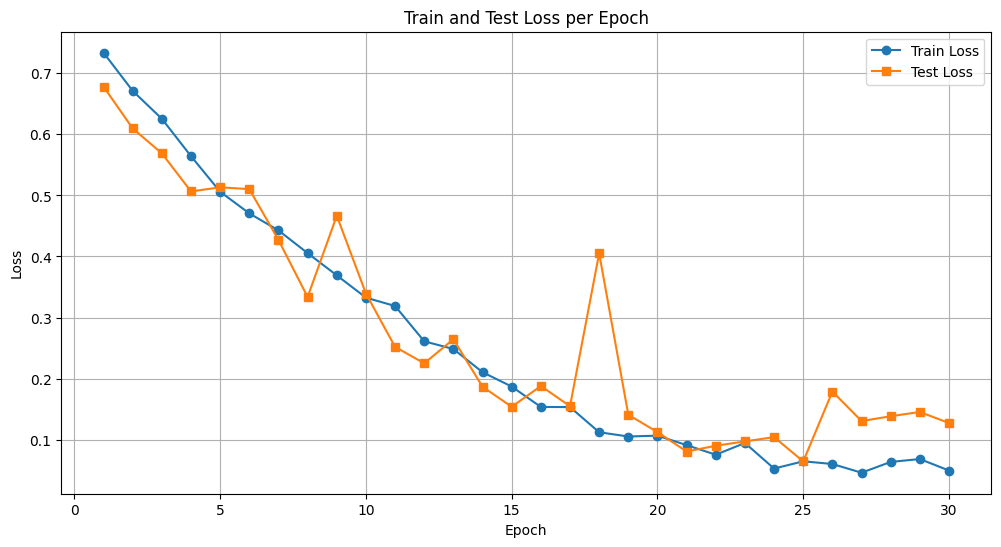

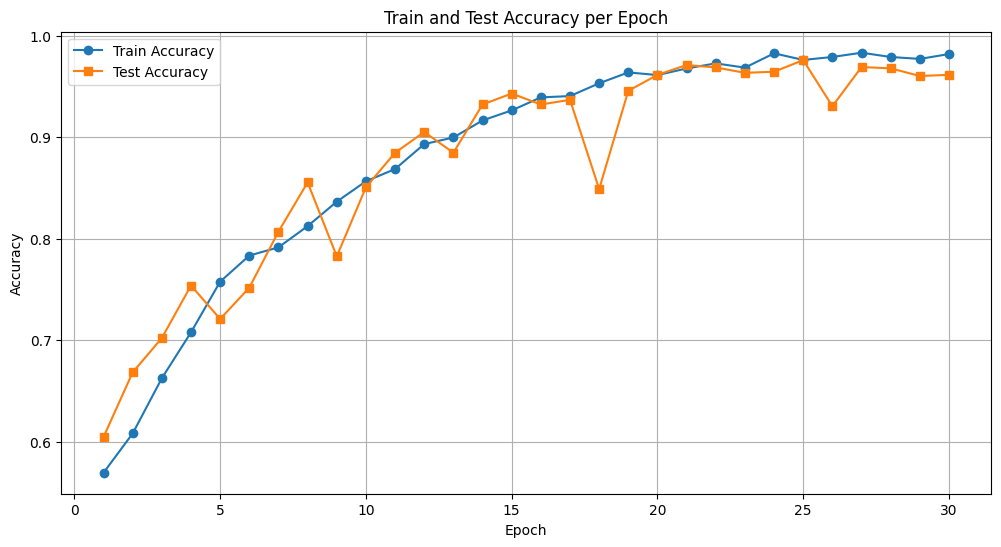

In [ ]:
import matplotlib.pyplot as plt

# Dữ liệu từ log
epochs = list(range(1, 31))  # Số epoch từ 1 đến 30
train_loss = [0.7337, 0.6712, 0.6255, 0.5643, 0.5060, 0.4706, 0.4427, 0.4055, 0.3691, 0.3326,
              0.3189, 0.2611, 0.2485, 0.2105, 0.1870, 0.1536, 0.1534, 0.1122, 0.1052, 0.1066,
              0.0911, 0.0754, 0.0946, 0.0527, 0.0646, 0.0602, 0.0459, 0.0636, 0.0683, 0.0495]
test_loss = [0.6781, 0.6097, 0.5689, 0.5065, 0.5133, 0.5103, 0.4270, 0.3337, 0.4667, 0.3393,
             0.2519, 0.2251, 0.2645, 0.1867, 0.1539, 0.1879, 0.1548, 0.4052, 0.1408, 0.1124,
             0.0806, 0.0901, 0.0972, 0.1042, 0.0644, 0.1788, 0.1305, 0.1384, 0.1454, 0.1273]
train_acc = [0.5696, 0.6083, 0.6627, 0.7079, 0.7578, 0.7835, 0.7916, 0.8125, 0.8366, 0.8567,
             0.8687, 0.8933, 0.8998, 0.9166, 0.9265, 0.9393, 0.9406, 0.9532, 0.9639, 0.9613,
             0.9678, 0.9728, 0.9686, 0.9827, 0.9762, 0.9791, 0.9833, 0.9791, 0.9772, 0.9820]
test_acc = [0.6048, 0.6685, 0.7023, 0.7540, 0.7210, 0.7519, 0.8071, 0.8556, 0.7827, 0.8508,
            0.8848, 0.9052, 0.8848, 0.9323, 0.9431, 0.9323, 0.9369, 0.8490, 0.9458, 0.9615,
            0.9712, 0.9688, 0.9635, 0.9646, 0.9760, 0.9306, 0.9692, 0.9679, 0.9604, 0.9615]

# Vẽ biểu đồ Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, test_loss, label='Test Loss', marker='s')
plt.title('Train and Test Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Vẽ biểu đồ Accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, test_acc, label='Test Accuracy', marker='s')
plt.title('Train and Test Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.show()